### Plot  data from Lamour et al. 

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

import functions_py.fates_xarray_functions as fa


In [2]:
dark = cm.get_cmap('Dark2', 8)
colormap = dark(range(8))

#### Load data from Lamour et al. 2023

In [3]:
data = pd.read_csv('/global/homes/j/jneedham/plot_data/Data_Vertical_Profiles.csv')
data = data[(data.Life_form != "LIANA") & (data.Life_form != "HEMIEPIPHYTIC VINE") & (data.Life_form != "HERB") & (data.Life_form) & (data.LAI) & (data.Rdark25) & (data.Vcmax25)]


In [4]:
data =  data.dropna(subset=['LAI', 'Rdark25'])

#### Function to fit parameters to Lamour et al. data given Atkin respiration model

In [5]:
def func(x,a, b):
    return (a + b * x) * (1.7560 + 0.2061 * (0.033/0.012) + -0.0402 * max(0, (298.15 - 273.15)))

In [6]:
optimizedParameters, pcov = opt.curve_fit(func, data['LAI'], data['Rdark25'])

print(optimizedParameters)
                                          

[ 0.76775866 -0.07549542]


''

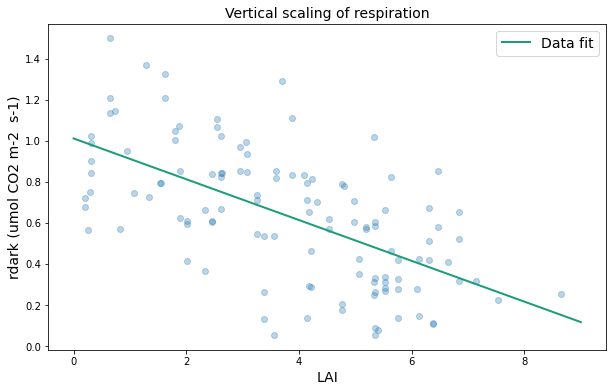

In [7]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
 
f2ax0.scatter(data['LAI'], data['Rdark25'], alpha = 0.3)

lai = np.linspace(0,9,10)
f2ax0.plot(lai, func(lai, *optimizedParameters), color=colormap[0], linewidth=2, label = 'Data fit')

f2ax0.set_title(r'Vertical scaling of respiration', fontsize = 14)
f2ax0.set_ylabel(r'rdark (umol CO2 m-2  s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
;

### Plot the four respiration schemes

#### Constants

In [8]:
vcmax25top = 50
lnc_top = 0.033 / 0.012  # g N leaf / slatop 
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
tfrz = 273.15
veg_tempk = 298.15
maintresp_leaf_ryan1991_baserate = 2.525e-06
lmrha = 46390
lmrhd = 150650
lmrse = 490
lmrc = 1.15912391
r0 = 1.756
r1 = 0.2061
r2 = -0.0402
tgrowth = 298.15

#### Lloyd scaling

In [9]:
kn = np.exp(0.00963 * vcmax25top - 2.43)
nscaler = np.exp(-kn * lai)

#### Ryan

In [10]:
def ft1_f (tl, ha):
    rgas = 8314.4598
    ans = np.exp( ha / (rgas*1e-3*(tfrz+25.)) * (1. - (tfrz+25.)/tl) ) 
    return(ans)

def fth_f(tl, hd, se, scaleFactor):
    rgas = 8314.4598
    ans = scaleFactor / ( 1. + np.exp( (-hd+se*tl) / (rgas*1.e-3*tl) ) )   
    return(ans)


In [11]:
lmr25top = maintresp_leaf_ryan1991_baserate * (1.5 ** ((25 - 20)/10))
lmr25top = lmr25top * lnc_top / (umolC_to_kgC * g_per_kg)

lmr25 = lmr25top * nscaler

lmr_ryan = lmr25 * ft1_f(veg_tempk, lmrha) * fth_f(veg_tempk, lmrhd, lmrse, lmrc)

#### Atkin, Lamour and Lloyd

In [12]:
# Atkin
lnc = lnc_top * nscaler
r_t_ref_atkin = r0 + r1 * lnc + r2 * max(0, (tgrowth - tfrz))

# Lamour
rdark_scaler = 0.80968934 + (-0.07883374 * lai)                                    
r_t_ref_lamour = rdark_scaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))  

# lloyd
r_t_ref_lloyd = nscaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))

lmr_atkin = r_t_ref_atkin * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 
lmr_lamour = r_t_ref_lamour * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2))
lmr_lloyd = r_t_ref_lloyd * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 


''

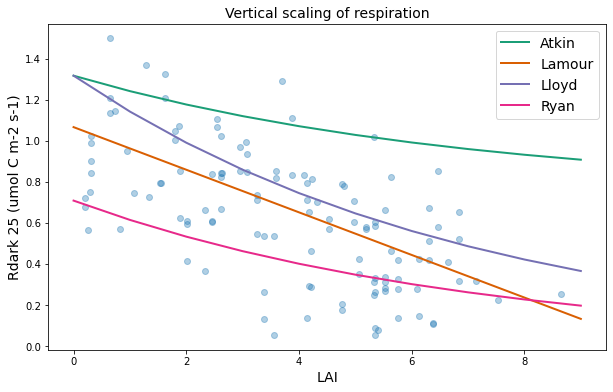

In [13]:
fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    
f2ax0.scatter(data['LAI'], data['Rdark25'], alpha=0.35)
    
f2ax0.plot(lai, lmr_atkin,  label = 'Atkin', color=colormap[0], linewidth=2)
f2ax0.plot(lai, lmr_lamour,  label = 'Lamour', color=colormap[1], linewidth=2)
f2ax0.plot(lai, lmr_lloyd,  label = 'Lloyd', color=colormap[2], linewidth=2)
f2ax0.plot(lai, lmr_ryan,  label = 'Ryan', color=colormap[3], linewidth=2)


f2ax0.set_title(r'Vertical scaling of respiration', fontsize = 14)
f2ax0.set_ylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
;

#### Offset terms so they all have same top of canopy rdark

In [14]:
atkin_offset = lmr_atkin[0] - lmr_lamour[0]
lloyd_offset = lmr_lloyd[0] - lmr_lamour[0]
ryan_offset = lmr_ryan[0] - lmr_lamour[0]

print(atkin_offset)
print(lloyd_offset)
print(ryan_offset)

0.25078662998150003
0.25078662998150003
-0.3582948587706195


In [15]:
# Atkin
lnc = lnc_top * nscaler
r_t_ref_atkin = r0 + r1 * lnc + r2 * max(0, (tgrowth - tfrz)) - atkin_offset
   
# lloyd
r_t_ref_lloyd = nscaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz))) - lloyd_offset

# Ryan 
lmr25top = maintresp_leaf_ryan1991_baserate * (1.5 ** ((25 - 20)/10))
lmr25top = lmr25top * lnc_top / (umolC_to_kgC * g_per_kg)
lmr25 = lmr25top * nscaler
lmr_ryan = lmr25 * ft1_f(veg_tempk, lmrha) * fth_f(veg_tempk, lmrhd, lmrse, lmrc) - ryan_offset


lmr_atkin = r_t_ref_atkin * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 
lmr_lloyd = r_t_ref_lloyd * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 


''

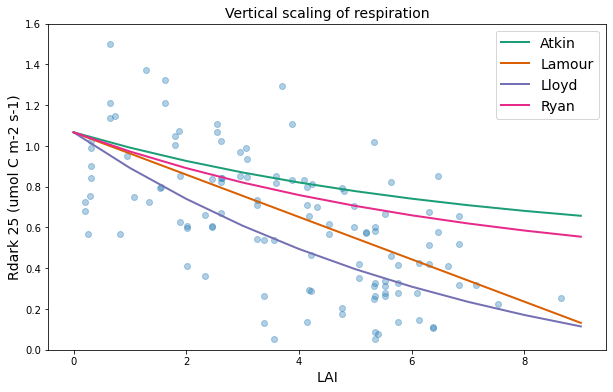

In [16]:
fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    
f2ax0.scatter(data['LAI'], data['Rdark25'], alpha=0.35)
    
f2ax0.plot(lai, lmr_atkin,  label = 'Atkin', color=colormap[0], linewidth=2)
f2ax0.plot(lai, lmr_lamour,  label = 'Lamour', color=colormap[1], linewidth=2)
f2ax0.plot(lai, lmr_lloyd,  label = 'Lloyd', color=colormap[2], linewidth=2)
f2ax0.plot(lai, lmr_ryan, label =  'Ryan',  color=colormap[3], linewidth=2)

f2ax0.set_title(r'Vertical scaling of respiration', fontsize = 14)
f2ax0.set_ylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
f2ax0.set_ylim(0,1.6)
;

### Now look at vcmax

In [17]:
data = pd.read_csv('/global/homes/j/jneedham/plot_data/Data_Vertical_Profiles.csv')
#data = data[(data.Life_form != "LIANA") & (data.Life_form != "HEMIEPIPHYTIC VINE") & (data.Life_form != "HERB") & (data.Life_form) & (data.LAI) & (data.Rdark25) & (data.Vcmax25)]

data.head(3)
data =  data.dropna(subset=['LAI', 'Vcmax25'])

In [18]:
def func(x, a, b, c):
    
    vcmax25top = 50
    veg_tempk = 298.15
    tfrz = 275.15
    
    nscaler = a + (b * x) + (c * x**2) 
    
    vcmax25 = vcmax25top * nscaler
    vcmax = vcmax25 * 2.**((veg_tempk - (tfrz + 25.)) / 10.)                                                                                         
    vcmax = vcmax / (1. + np.exp( 0.2 * ((tfrz + 15.) - veg_tempk ) ))                                                                                  
    vcmax = vcmax / (1. + np.exp( 0.3 * (veg_tempk - (tfrz + 40.)) ))
    
    return ( vcmax )

In [19]:
optimizedParameters, pcov = opt.curve_fit(func, data['LAI'], data['Vcmax25'])

print(optimizedParameters)
                                          

[ 2.07652636 -0.0653725  -0.00921654]


In [20]:
nscaler_lamour = 2.07652636 + (-0.0653725 * lai) + (-0.00921654 * lai**2)
vcmax25_lamour = vcmax25top * nscaler_lamour
vcmax_lamour = vcmax25_lamour * 2.**((veg_tempk - (tfrz + 25.)) / 10.)                                                                                         
vcmax_lamour = vcmax_lamour / (1. + np.exp( 0.2 * ((tfrz + 15.) - veg_tempk ) ))                                                                                  
vcmax_lamour = vcmax_lamour / (1. + np.exp( 0.3 * (veg_tempk - (tfrz + 40.)) ))

''

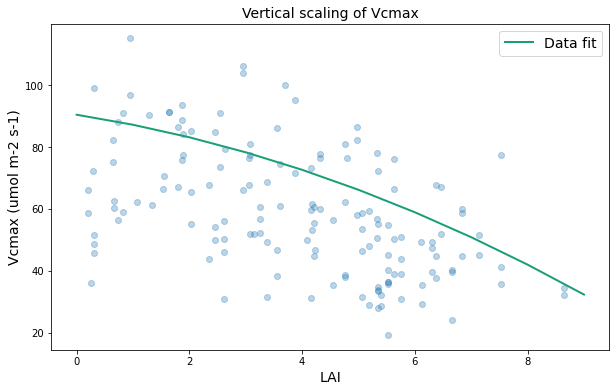

In [21]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
 
f2ax0.scatter(data['LAI'], data['Vcmax25'], alpha = 0.3)

#f2ax0.plot(lai, func(lai, *optimizedParameters), color=colormap[0], linewidth=2, label = 'Data fit')
f2ax0.plot(lai,  vcmax_lamour, color=colormap[0], linewidth=2, label = 'Data fit')
f2ax0.set_title(r'Vertical scaling of Vcmax', fontsize = 14)
f2ax0.set_ylabel(r'Vcmax (umol m-2 s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
#f2ax0.set_ylim(0,110)
;

#### Using Lloyd scaling

In [22]:
kn = np.exp(0.00963 * vcmax25top - 2.43)
nscaler = np.exp(-kn * lai)

In [23]:
vcmax25 = vcmax25top * nscaler

vcmax = vcmax25 * 2.**((veg_tempk - (tfrz + 25.)) / 10.)                                                                                         
vcmax = vcmax / (1. + np.exp( 0.2 * ((tfrz + 15.) - veg_tempk ) ))                                                                                  
vcmax = vcmax / (1. + np.exp( 0.3 * (veg_tempk - (tfrz + 40.)) ))

''

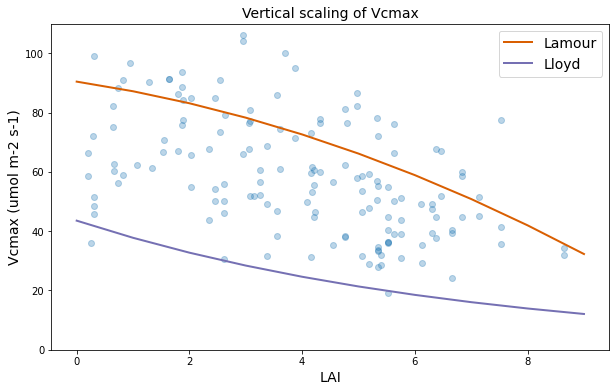

In [24]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
 
f2ax0.scatter(data['LAI'], data['Vcmax25'], alpha = 0.3)

f2ax0.plot(lai, vcmax_lamour, color=colormap[1], linewidth=2, label = 'Lamour')
f2ax0.plot(lai, vcmax, color=colormap[2], linewidth=2, label = 'Lloyd')

f2ax0.set_title(r'Vertical scaling of Vcmax', fontsize = 14)
f2ax0.set_ylabel(r'Vcmax (umol m-2 s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
f2ax0.set_ylim(0,110)
;

#### Offset so they have same Vcmax at top of canopy

In [25]:
offset = vcmax_lamour[0] - vcmax[0]

In [26]:
vcmax = vcmax + offset

''

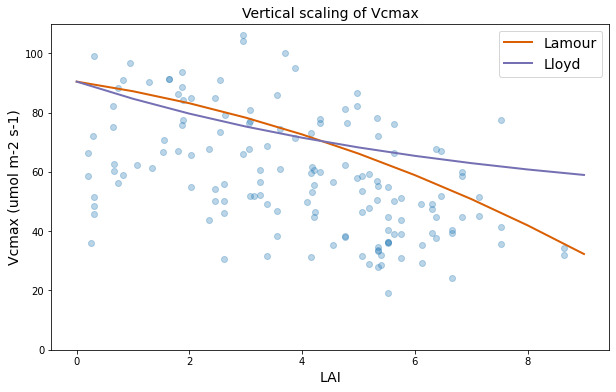

In [27]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
 
f2ax0.scatter(data['LAI'], data['Vcmax25'], alpha = 0.3)
f2ax0.plot(lai, vcmax_lamour, color=colormap[1], linewidth=2, label = 'Lamour')
f2ax0.plot(lai, vcmax, color=colormap[2], linewidth=2, label = 'Lloyd')

f2ax0.set_title(r'Vertical scaling of Vcmax', fontsize = 14)
f2ax0.set_ylabel(r'Vcmax (umol m-2 s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
f2ax0.set_ylim(0,110)
;

### Ratio  of vcmax to rdark using  each combination

In [28]:
rdarklloyd_vcmaxlloyd = lmr_lloyd / vcmax
rdarklloyd_vcmaxlamour = lmr_lloyd / vcmax_lamour

rdarklamour_vcmaxlloyd = lmr_lamour / vcmax
rdarklamour_vcmaxlamour = lmr_lamour / vcmax_lamour

rdarkatkin_vcmaxlloyd = lmr_atkin / vcmax
rdarkatkin_vcmaxlamour = lmr_atkin / vcmax_lamour


''

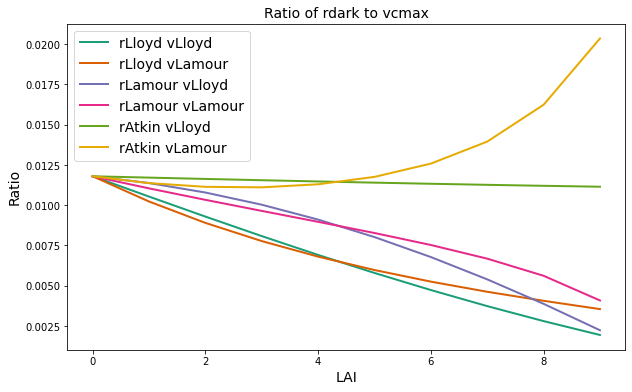

In [29]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
 
f2ax0.plot(lai, rdarklloyd_vcmaxlloyd, linewidth=2, color=colormap[0], label = 'rLloyd vLloyd')
f2ax0.plot(lai, rdarklloyd_vcmaxlamour, linewidth=2, color=colormap[1], label = 'rLloyd vLamour')
f2ax0.plot(lai, rdarklamour_vcmaxlloyd, linewidth=2, color=colormap[2], label = 'rLamour vLloyd')
f2ax0.plot(lai, rdarklamour_vcmaxlamour, linewidth=2, color=colormap[3], label = 'rLamour vLamour')
f2ax0.plot(lai, rdarkatkin_vcmaxlloyd, linewidth=2, color=colormap[4], label = 'rAtkin vLloyd')
f2ax0.plot(lai, rdarkatkin_vcmaxlamour, linewidth=2, color=colormap[5], label = 'rAtkin vLamour')


f2ax0.set_title(r'Ratio of rdark to vcmax', fontsize = 14)
f2ax0.set_ylabel(r'Ratio', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)

;

- high numbers mean more respiration to photosynthesis
- low numbers mean less respiraiton to photosynthesis